# Import data
Import data from a file containing the preprocessed dataset.

In [272]:
import pandas as pd
import os

V1 = 'First'
V2 = 'Second'
V3 = 'Third'

# depending on the OS the path to the data file is different
if os.name == 'nt':
    first_data = pd.read_csv(r'..\data\generated\preprocessed-data-classification-first.csv')
    second_data = pd.read_csv(r'..\data\generated\preprocessed-data-classification-second.csv')
    third_data = pd.read_csv(r'..\data\generated\preprocessed-data-classification-third.csv')
    food_groups = pd.read_excel(r'..\data\food-groups.xls')
elif os.name == 'posix':
    first_data = pd.read_csv(r'../data/generated/preprocessed-data-classification-first.csv')
    second_data = pd.read_csv(r'../data/generated/preprocessed-data-classification-second.csv')
    third_data = pd.read_csv(r'../data/generated/preprocessed-data-classification-third.csv')
    food_groups = pd.read_excel(r'../data/food-groups.xls')

# filter food groups with 'Food Group Code' with length 2
food_groups = food_groups[food_groups['Food Group Code'].apply(lambda x: len(str(x)) == 2)]


print('First version of food groups:')
first_data.head()

First version of food groups:


,Public Food Key,Classification,Food Name,"Energy with dietary fibre, equated \n(kJ)","Energy, without dietary fibre, equated \n(kJ)",Moisture (water) \n(g),Protein \n(g),Nitrogen \n(g),"Fat, total \n(g)",Ash \n(g),...,C22:5w3 (mg),C22:4w6 (mg),C22:6w3 (mg),"Total polyunsaturated fatty acids, equated \n(g)","Total long chain omega 3 fatty acids, equated \n(mg)","Total undifferentiated fatty acids, mass basis basis \n(mg)","Total trans fatty acids, imputed \n(mg)",Cholesterol \n(mg),Tryptophan \n(mg/gN),Tryptophan \n(mg)
0,F002258,31,"Cardamom seed, dried, ground",1236,1012,8.3,10.8,1.72,6.7,5.8,...,0.00,31.0,0.0,1.39,0.000,31.0,0.0,0,90.0,155
1,F002893,31,"Chilli (chili), dried, ground",1280,1002,10.8,13.4,2.14,14.3,11.8,...,0.00,31.0,0.0,6.69,0.000,31.0,0.0,0,32.0,69
2,F002963,31,"Cinnamon, dried, ground",1004,579,10.6,4.0,0.64,1.2,3.6,...,0.00,31.0,0.0,0.12,0.000,31.0,0.0,0,77.0,49
3,F002970,31,"Cloves, dried, ground",1389,1118,9.9,6.0,0.96,13.0,5.6,...,255.52,31.0,0.0,5.03,266.581,31.0,0.0,0,31.0,30
4,F003190,31,"Coriander seed, dried, ground",1344,1009,8.9,12.4,1.98,17.8,6.0,...,0.00,31.0,0.0,1.82,0.000,31.0,0.0,0,90.0,178


---
# Prepare data
1. Determine the target variable.
2. Determine the features.
3. Split the data into training and test sets.

In [273]:
def feat_and_target(data, v):
    # use nutrition columns as features
    X_COLS = list(data.columns[3:])

    # use classification column as target
    y_COL = data.columns[1]

    print(f"{v} version:")
    print(f"X_COLS: {X_COLS}")
    print(f"y_COL: {y_COL}\n")
    return X_COLS, y_COL

first_X_COLS, first_y_COL = feat_and_target(first_data, V1)
second_X_COLS, second_y_COL = feat_and_target(second_data, V2)
third_X_COLS, third_y_COL = feat_and_target(third_data, V3)

First version:
X_COLS: ['Energy with dietary fibre, equated \n(kJ)', 'Energy, without dietary fibre, equated \n(kJ)', 'Moisture (water) \n(g)', 'Protein \n(g)', 'Nitrogen \n(g)', 'Fat, total \n(g)', 'Ash \n(g)', 'Total dietary fibre \n(g)', 'Fructose \n(g)', 'Glucose \n(g)', 'Sucrose\n(g)', 'Total sugars (g)', 'Added sugars (g)', 'Free sugars \n(g)', 'Starch \n(g)', 'Available carbohydrate, without sugar alcohols \n(g)', 'Available carbohydrate, with sugar alcohols \n(g)', 'Citric acid \n(g)', 'Lactic acid \n(g)', 'Malic acid\n (g)', 'Oxalic acid \n(g)', 'Quinic acid \n(g)', 'Calcium (Ca) \n(mg)', 'Chloride (Cl) \n(mg)', 'Copper (Cu) \n(mg)', 'Iodine (I) \n(ug)', 'Iron (Fe) \n(mg)', 'Magnesium (Mg) \n(mg)', 'Manganese (Mn) \n(mg)', 'Molybdenum (Mo) \n(ug)', 'Phosphorus (P) \n(mg)', 'Potassium (K) \n(mg)', 'Selenium (Se) \n(ug)', 'Sodium (Na) \n(mg)', 'Sulphur (S) \n(mg)', 'Zinc (Zn) \n(mg)', 'Retinol (preformed vitamin A) \n(ug)', 'Alpha-carotene \n(ug)', 'Beta-carotene \n(ug)', 'Beta-

In [274]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.15

def train_test_data(data, X_COLS, y_COL):
    # split data into train and test sets
    train, test = train_test_split(data, test_size=TEST_SIZE, random_state=43)

    # create design matrix X and predictions y
    X_train = train[X_COLS]
    y_train = train[y_COL]
    X_test = test[X_COLS]
    y_test = test[y_COL]

    # replace NaN values with 0
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    y_train = y_train.fillna(0)
    y_test = y_test.fillna(0)

    return X_train, y_train, X_test, y_test

first_X_train, first_y_train, first_X_test, first_y_test = train_test_data(first_data, first_X_COLS, first_y_COL)
second_X_train, second_y_train, second_X_test, second_y_test = train_test_data(second_data, second_X_COLS, second_y_COL)
third_X_train, third_y_train, third_X_test, third_y_test = train_test_data(third_data, third_X_COLS, third_y_COL)

print(first_y_train.head(50))
# print(second_X_test)
# print(third_X_test)


243     13
423     31
978     18
48      31
530     31
393     31
1433    24
565     16
1361    31
1415    24
751     18
29      31
1346    31
596     16
391     31
834     18
127     13
1220    15
694     31
384     31
681     31
935     18
1604    24
640     16
261     12
381     31
233     13
920     18
427     31
189     12
965     18
1208    15
1206    15
742     18
539     31
119     13
1409    24
114     13
1199    31
1204    15
34      31
207     12
1522    24
500     31
1336    31
983     18
228     13
1060    18
1234    15
36      31
Name: Classification, dtype: int64


---
# $k$-nn
We create a $k$-nn model which is used to classify a food into different food groups based on its nutritional information.

First we determine the best $k$ value based on the accuracy of different models.

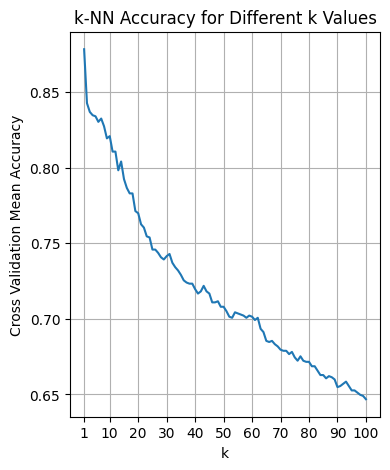

First version:
[[0.878377234740294, 1], [0.8426795726224479, 2], [0.8368930498254521, 3], [0.8347085581296942, 4], [0.8339997884269543, 5], [0.8325081984555167, 7], [0.8303289960858986, 6], [0.8273881307521422, 8], [0.8208611022955676, 10], [0.8194065376071089, 9], [0.8106527028456574, 11], [0.8106474135195176, 12], [0.8040939384322439, 14], [0.7982703903522691, 13], [0.7924732889029938, 15], [0.7866285835184598, 16], [0.7830001057865228, 17], [0.7829683698296837, 18], [0.7713159843435946, 19], [0.7698455516767165, 20], [0.7625515709298635, 21], [0.7603776578863852, 22], [0.7545593991325504, 23], [0.7538347614513912, 24], [0.7458214323495187, 25], [0.7458214323495186, 26], [0.7436422299799006, 27], [0.7429123029726012, 31], [0.7414736062625622, 30], [0.7407278112768433, 28], [0.7392732465883848, 29], [0.7370940442187666, 32], [0.7341796255157094, 33], [0.7320004231460912, 34], [0.729086004443034, 35], [0.7254575267110971, 36], [0.7240029620226383, 37], [0.7232783243414789, 39], [0.7232

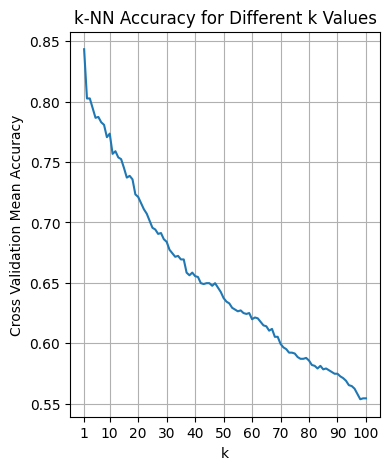

Second version:
[[0.8434359462604464, 1], [0.8026763990267639, 3], [0.8026340844176453, 2], [0.7946630699248916, 4], [0.7873479318734793, 6], [0.7866338728445996, 5], [0.7829525018512642, 7], [0.7807997461123453, 8], [0.7735375013223316, 10], [0.7706072146408548, 9], [0.7589495398286258, 12], [0.7567756267851475, 11], [0.7538453401036707, 13], [0.7523960647413519, 14], [0.7451126626467788, 15], [0.7385538982333651, 17], [0.7371046228710462, 16], [0.7356447688564478, 18], [0.7232307204062203, 19], [0.7210620966888819, 20], [0.7159684756162065, 21], [0.710874854543531, 22], [0.7072252195070348, 23], [0.7014122500793399, 24], [0.6955728340209457, 25], [0.6941288479847667, 26], [0.6912038506294298, 28], [0.6904792129482704, 27], [0.6860943615783348, 29], [0.6839151592087168, 30], [0.6773511054691632, 31], [0.6744313974399662, 32], [0.6722627737226278, 34], [0.6715328467153284, 33], [0.6693430656934306, 35], [0.6693377763672907, 36], [0.6584258965407808, 39], [0.6584047392362213, 37], [0.65

/Users/david/development/projects/python/comp20008-assignment-2/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/david/development/projects/python/comp20008-assignment-2/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/david/development/projects/python/comp20008-assignment-2/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/david/development/projects/python/comp20008-assignment-2/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.wa

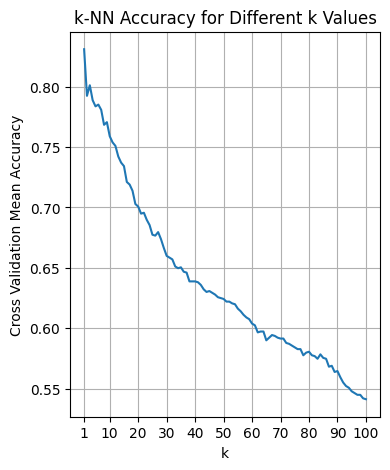

Third version:
[[0.8310430551147784, 1], [0.8012006770337459, 3], [0.792462710250714, 2], [0.7888289431926373, 4], [0.7851845974822809, 6], [0.783730032793822, 5], [0.7808314820691844, 7], [0.770633661271554, 9], [0.7684438802496562, 8], [0.7589865651116049, 10], [0.7538876547127896, 11], [0.7509732360097324, 12], [0.7422141119221412, 13], [0.7371204908494657, 14], [0.7342272294509679, 15], [0.7211202792764202, 16], [0.7189357875806622, 17], [0.7138315878557072, 18], [0.7028932613984978, 19], [0.7007034803766, 20], [0.6956098593039248, 22], [0.6948852216227652, 21], [0.6897757325716704, 23], [0.6854120385062944, 24], [0.6795884904263197, 27], [0.6774092880567018, 25], [0.6766740717232624, 26], [0.6737543636940653, 28], [0.6664603829472124, 29], [0.659896329207659, 30], [0.6584523431714799, 31], [0.6569819105046018, 32], [0.6511424944462074, 33], [0.650417856765048, 35], [0.6496826404316091, 34], [0.6467629324024119, 36], [0.6460488733735321, 37], [0.6387760499312389, 39], [0.6387760499

<Figure size 640x480 with 0 Axes>

In [275]:
# find the best k based on accuracy using cross validation

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

def cross_validate(X_train, y_train, v):
    # create list of possible k values from 1 to 100
    k_values = list(range(1, 101))

    # create list of cross validation scores
    cv_scores = []

    # perform 10-fold cross validation for each k 
    # and take the mean of the scores
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # plot the accuracy for each k
    plt.plot(k_values, cv_scores)
    plt.xlabel("k")
    plt.ylabel("Cross Validation Mean Accuracy")

    # add xtick for every 5th k
    plt.xticks([1] + list(range(10, 91, 10)) + [100])

    plt.grid()
    plt.gcf().set_size_inches(4, 5)
    plt.title("k-NN Accuracy for Different k Values")

    # save the plot
    plt.savefig(f'../report/figs/knn-cross-validation-{v.lower()}.png', bbox_inches='tight')
    plt.show()
    plt.clf()

    # find best k, other than k of 1
    cv_scores = [[score, k] for score, k in zip(cv_scores, k_values)]
    cv_scores = sorted(cv_scores)
    if cv_scores[::-1][0][1] == 1:
        best_k = cv_scores[::-1][1][1]
        best_k_accuracy = cv_scores[::-1][1][0]
    else:
        best_k = cv_scores[::-1][0][1]
        best_k_accuracy = cv_scores[::-1][0][0]

    print(f"{v} version:")
    print(cv_scores[::-1])
    print(f"Best k: {best_k}")
    print(f"Best k accuracy: {best_k_accuracy}\n")

    return best_k

first_best_k = cross_validate(first_X_train, first_y_train, V1)
second_best_k = cross_validate(second_X_train, second_y_train, V2)
third_best_k = cross_validate(third_X_train, third_y_train, V3)

In [276]:
import numpy as np
# create knn with best_k neighbors
first_knn = KNeighborsClassifier(n_neighbors=first_best_k)
# train the model using the training set
first_knn.fit(first_X_train, first_y_train)
# get first y prediction
first_y_pred = first_knn.predict(first_X_test)


# create knn with best_k neighbors
second_knn = KNeighborsClassifier(n_neighbors=second_best_k)
# train the model using the training set
second_knn.fit(second_X_train, second_y_train)
# get first y prediction
second_y_pred = second_knn.predict(second_X_test)


# create knn with best_k neighbors
third_knn = KNeighborsClassifier(n_neighbors=third_best_k)
# train the model using the training set
third_knn.fit(third_X_train, third_y_train)
# get first y prediction
third_y_pred = third_knn.predict(third_X_test)


## Evaluation
Calculate certain metrics to evaluate the model.

### Accuracy

In [277]:
# check the accuracy
from sklearn.metrics import accuracy_score

def print_accuracy_and_predictions(y_test, y_pred, v):
    print(f"{v} version:")
    # y_test constains the true labels of the test set
    # y_pred contains the predicted labels of the test set
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\tAccuracy: {accuracy}")

    # compare manually predicted labels with the true labels
    print(f"\tFirst few predictions: {y_pred[:10]}")
    print(f"\tFirst few true labels: {y_test[:10].values}\n")

    return accuracy
    
print_accuracy_and_predictions(first_y_test, first_y_pred, V1)
print_accuracy_and_predictions(second_y_test, second_y_pred, V2)
print_accuracy_and_predictions(third_y_test, third_y_pred, V3)

First version:
	Accuracy: 0.8847736625514403
	First few predictions: [24 31 24 31 18 18 31 13 31 31]
	First few true labels: [24 31 24 31 18 31 31 31 31 13]

Second version:
	Accuracy: 0.8518518518518519
	First few predictions: [24 22 24 31 18 18 28 13 11 23]
	First few true labels: [24 22 24 31 18 31 28 31 19 13]

Third version:
	Accuracy: 0.8395061728395061
	First few predictions: [24 22 24 27 18 12 28 13 11 23]
	First few true labels: [24 22 24 27 18 17 28 31 19 13]



0.8395061728395061

### Confusion Matrix

First version:
Correct predictions per food group:
24: 26 (Vegetable products and dishes)
31: 45 (Miscellaneous)
18: 83 (Meat, poultry and game products and dishes)
13: 10 (Cereal based products and dishes)
15: 18 (Fish and seafood products and dishes)
16: 10 (Fruit products and dishes)
12: 23 (Cereals and cereal products)


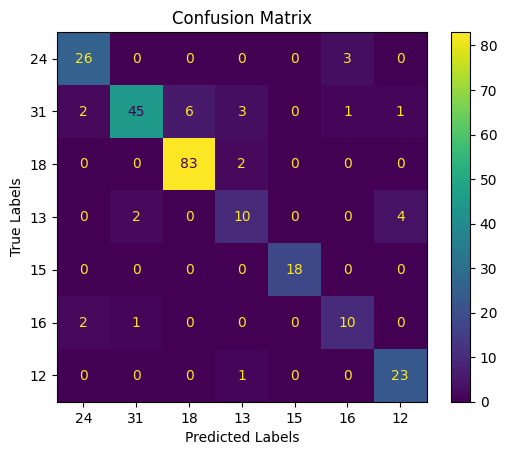

Second version:
Correct predictions per food group:
24: 27 (Vegetable products and dishes)
22: 3 (Seed and nut products and dishes)
31: 8 (Miscellaneous)
18: 84 (Meat, poultry and game products and dishes)
28: 2 (Confectionery and cereal/nut/fruit/seed bars)
19: 7 (Milk products and dishes)
13: 10 (Cereal based products and dishes)
15: 17 (Fish and seafood products and dishes)
16: 7 (Fruit products and dishes)
11: 6 (Non-alcoholic beverages)
12: 23 (Cereals and cereal products)
14: 7 (Fats and oils)
20: 2 (Dairy & meat substitutes)
23: 4 (Savoury sauces and condiments)


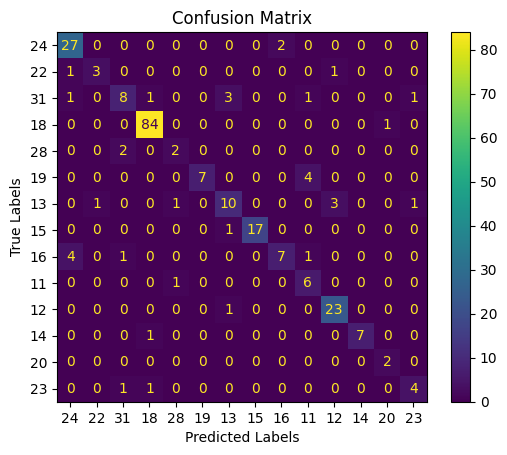

Third version:
Correct predictions per food group:
24: 25 (Vegetable products and dishes)
22: 3 (Seed and nut products and dishes)
27: 2 (Sugar products and dishes)
18: 84 (Meat, poultry and game products and dishes)
17: 1 (Egg products and dishes)
28: 2 (Confectionery and cereal/nut/fruit/seed bars)
31: 1 (Miscellaneous)
19: 8 (Milk products and dishes)
13: 10 (Cereal based products and dishes)
25: 2 (Legume and pulse products and dishes)
15: 16 (Fish and seafood products and dishes)
16: 8 (Fruit products and dishes)
11: 4 (Non-alcoholic beverages)
12: 23 (Cereals and cereal products)
14: 7 (Fats and oils)
21: 1 (Soup)
20: 2 (Dairy & meat substitutes)
26: 0 (Snack foods)
23: 4 (Savoury sauces and condiments)
29: 1 (Alcoholic beverages)


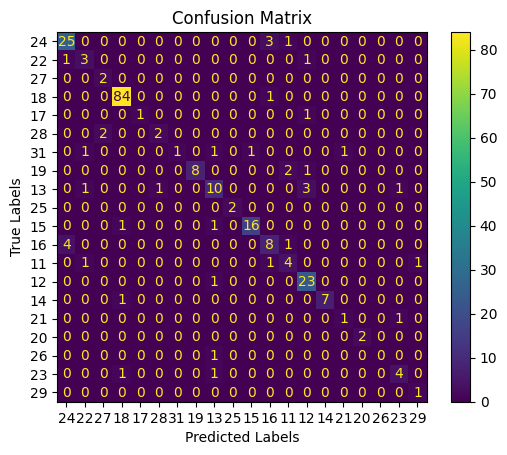

In [278]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def print_cm(y_test, y_pred, v, save_fig=False):
    print(f"{v} version:")

    # count the number of correct predictions
    print("Correct predictions per food group:")
    for value in y_test.unique():
        correct = 0
        for i in range(len(y_test)):
            if y_test.values[i] == y_pred[i] and y_test.values[i] == value:
                correct += 1
        food_group_name = food_groups[food_groups['Food Group Code'] == value]['Food Group and Sub-Group Name'].values[0].strip()
        print(f"{value}: {correct} ({food_group_name})")

    # create confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())

    # create confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # plot confusion matrix
    disp.plot()
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # plot the labels on the x and y axis
    plt.xticks(range(len(y_test.unique())), y_test.unique())
    plt.yticks(range(len(y_test.unique())), y_test.unique())

    plt.show()

    if save_fig:
        disp.figure_.savefig(f'../report/figs/knn-confusion-matrix-{v.lower()}.png', bbox_inches='tight')

print_cm(first_y_test, first_y_pred, V1, save_fig=True)
print_cm(second_y_test, second_y_pred, V2, save_fig=True)
print_cm(third_y_test, third_y_pred, V3, save_fig=True)


### Cross Validation


In [279]:
from sklearn.model_selection import KFold
SPLIT_COUNT = 7
V1 = 'First'
V2 = 'Second'
V3 = 'Third'
def cross_val_print(X_train, y_train, X_test, y_test, y_pred, k_val, data, X_COLS, y_COL, v):
    # splits the data into subsets
    kfold = KFold(n_splits=SPLIT_COUNT, shuffle=True, random_state=43)

    accuracy_scores = []
    for train, test in kfold.split(data):
        # create design matrix X and predictions y
        X_train = data.iloc[train][X_COLS]
        y_train = data.iloc[train][y_COL]
        X_test = data.iloc[test][X_COLS]
        y_test = data.iloc[test][y_COL]

        # reinitialise knn model
        knn = KNeighborsClassifier(n_neighbors=k_val)

        # train the model using the training subset
        knn.fit(X_train, y_train)
        
        # predict and show
        y_pred = knn.predict(X_test)

        # print_accuracy_and_predictions(y_test, y_pred, v)
        # print_cm(y_test, y_pred, v)

        # add accuracy to list
        accuracy_scores.append(accuracy_score(y_test, y_pred))

    # print average accuracy
    print(f"{v} average accuracy score across {len(accuracy_scores)} CV splits: {sum(accuracy_scores) / len(accuracy_scores)}")

cross_val_print(first_X_train, first_y_train, first_X_test, first_y_test, first_y_pred, first_best_k, first_data, first_X_COLS, first_y_COL, V1)
cross_val_print(second_X_train, second_y_train, second_X_test, second_y_test, second_y_pred, second_best_k, second_data, second_X_COLS, second_y_COL, V2)
cross_val_print(third_X_train, third_y_train, third_X_test, third_y_test, third_y_pred, third_best_k, third_data, third_X_COLS, third_y_COL, V3)


First average accuracy score across 7 CV splits: 0.8477749993277942
Second average accuracy score across 7 CV splits: 0.8131322094055012
Third average accuracy score across 7 CV splits: 0.8069317845715361


### Bootstrap Validation

Bootstrapped accuracies: [0.9053168244719592, 0.9045884923525127, 0.911143481427531, 0.9133284777858703, 0.9133284777858703, 0.9031318281136198, 0.8973051711580481, 0.9060451565914057, 0.9031318281136198, 0.9075018208302986, 0.9009468317552805, 0.9075018208302986, 0.9147851420247632, 0.9118718135469774, 0.9024034959941734, 0.9082301529497451, 0.8965768390386016, 0.9147851420247632, 0.9169701383831027, 0.9169701383831027, 0.9082301529497451, 0.9133284777858703, 0.9147851420247632, 0.9031318281136198, 0.909686817188638, 0.8965768390386016, 0.9045884923525127, 0.911143481427531, 0.8980335032774945, 0.9162418062636563, 0.9089584850691915, 0.922068463219228, 0.9045884923525127, 0.9075018208302986, 0.9075018208302986, 0.9118718135469774, 0.898761835396941, 0.9089584850691915, 0.9118718135469774, 0.911143481427531, 0.9198834668608885, 0.9133284777858703, 0.9191551347414421, 0.8980335032774945, 0.9002184996358339, 0.9024034959941734, 0.9169701383831027, 0.909686817188638, 0.9082301529497451, 0

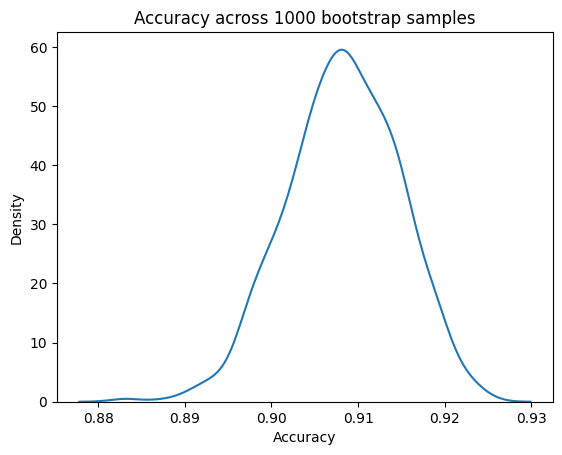

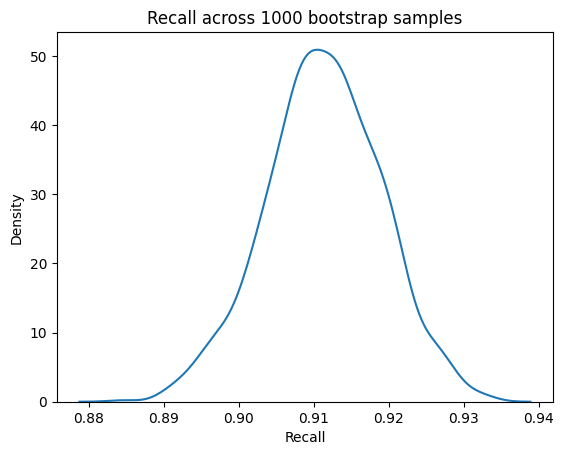

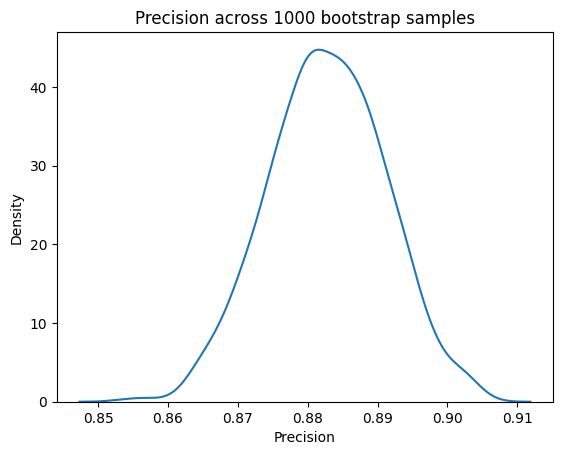

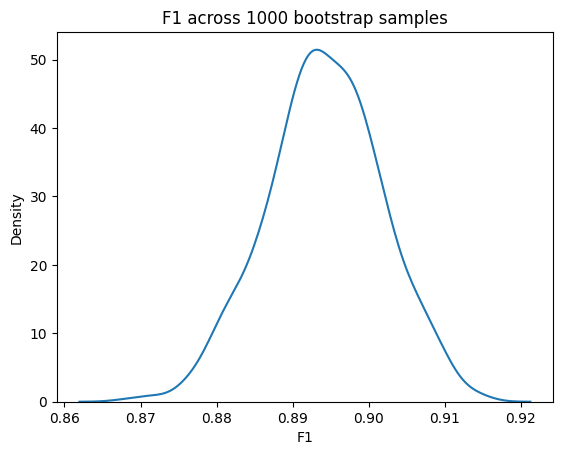

Bootstrapped accuracies: [0.8710852148579752, 0.8659868900218499, 0.875455207574654, 0.8630735615440641, 0.8506919155134741, 0.8623452294246177, 0.8747268754552076, 0.8616168973051711, 0.876911871813547, 0.8689002184996358, 0.8623452294246177, 0.8718135469774217, 0.8747268754552076, 0.8681718863801894, 0.8659868900218499, 0.8718135469774217, 0.8565185724690458, 0.8557902403495994, 0.8798252002913328, 0.8732702112163147, 0.8747268754552076, 0.8725418790968682, 0.8681718863801894, 0.875455207574654, 0.8623452294246177, 0.8703568827385287, 0.8667152221412965, 0.8616168973051711, 0.8696285506190823, 0.8638018936635106, 0.8725418790968682, 0.864530225782957, 0.85360524399126, 0.8572469045884924, 0.8776402039329935, 0.8805535324107793, 0.8557902403495994, 0.8667152221412965, 0.8608885651857247, 0.8718135469774217, 0.8652585579024035, 0.8616168973051711, 0.8689002184996358, 0.8718135469774217, 0.8696285506190823, 0.8776402039329935, 0.8667152221412965, 0.876911871813547, 0.8667152221412965, 0

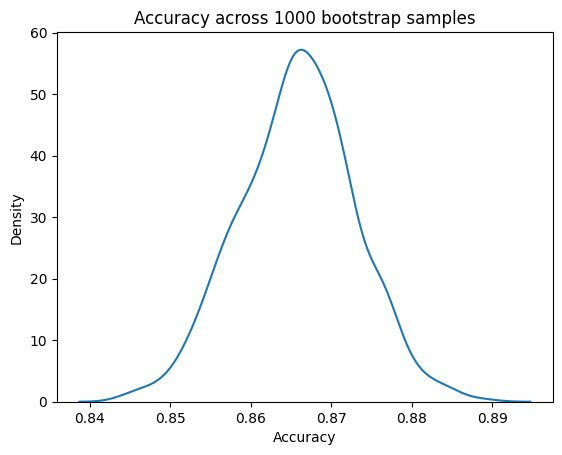

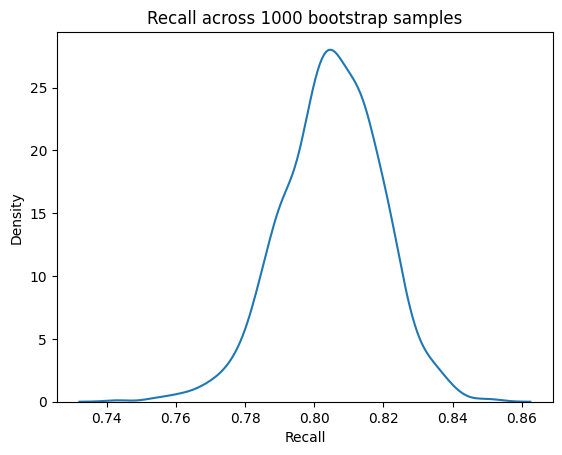

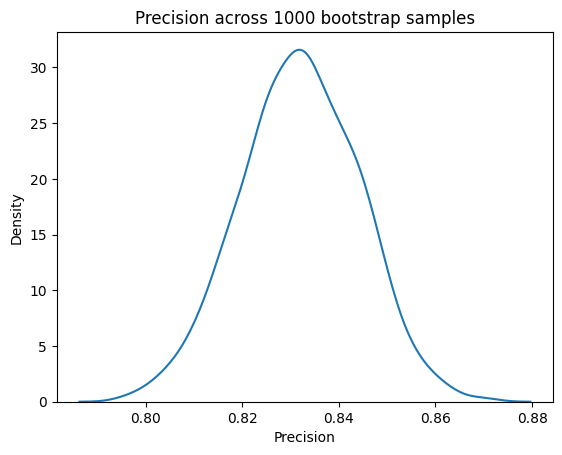

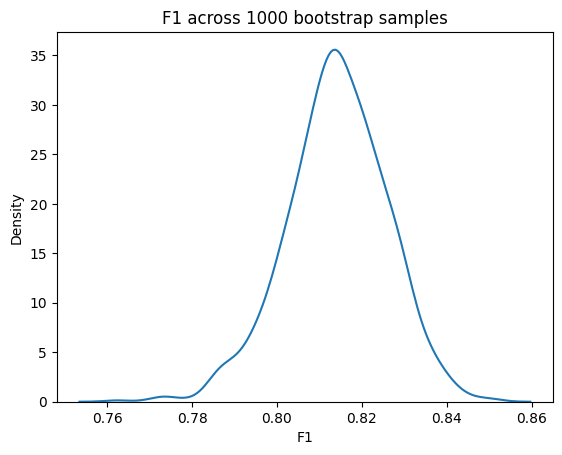

/Users/david/development/projects/python/comp20008-assignment-2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/david/development/projects/python/comp20008-assignment-2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/david/development/projects/python/comp20008-assignment-2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

Bootstrapped accuracies: [0.8397669337217771, 0.8528769118718136, 0.8638018936635106, 0.8652585579024035, 0.8485069191551348, 0.8543335761107065, 0.8506919155134741, 0.8506919155134741, 0.8463219227967953, 0.8761835396941005, 0.8499635833940277, 0.8659868900218499, 0.8667152221412965, 0.8594319009468318, 0.8557902403495994, 0.8630735615440641, 0.8681718863801894, 0.8703568827385287, 0.8361252731245448, 0.8550619082301529, 0.8587035688273853, 0.8463219227967953, 0.8492352512745812, 0.8579752367079388, 0.842680262199563, 0.8579752367079388, 0.8485069191551348, 0.8572469045884924, 0.8587035688273853, 0.8528769118718136, 0.8616168973051711, 0.8557902403495994, 0.8659868900218499, 0.8667152221412965, 0.8667152221412965, 0.8404952658412236, 0.8616168973051711, 0.8455935906773488, 0.8572469045884924, 0.8572469045884924, 0.8587035688273853, 0.8543335761107065, 0.8499635833940277, 0.8608885651857247, 0.8521485797523671, 0.8550619082301529, 0.8732702112163147, 0.8638018936635106, 0.8659868900218

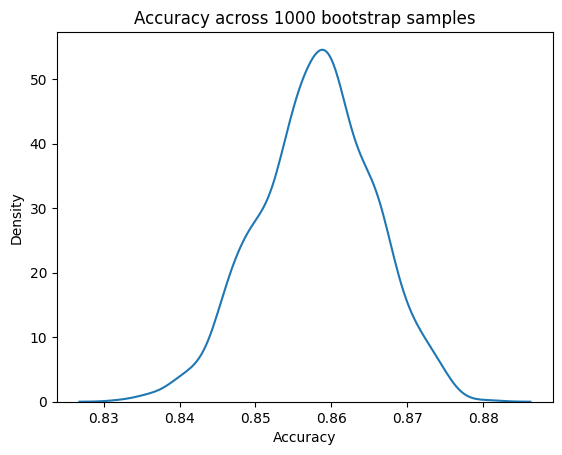

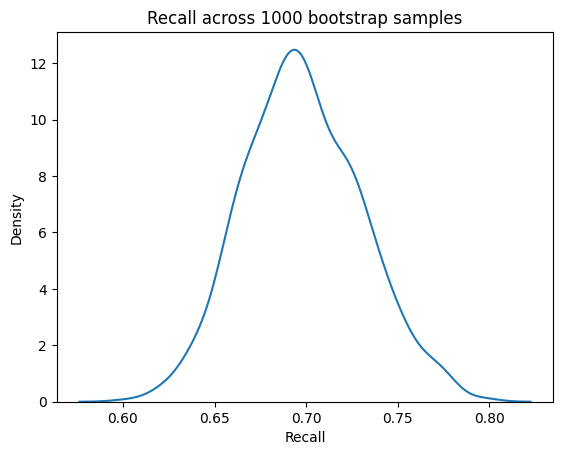

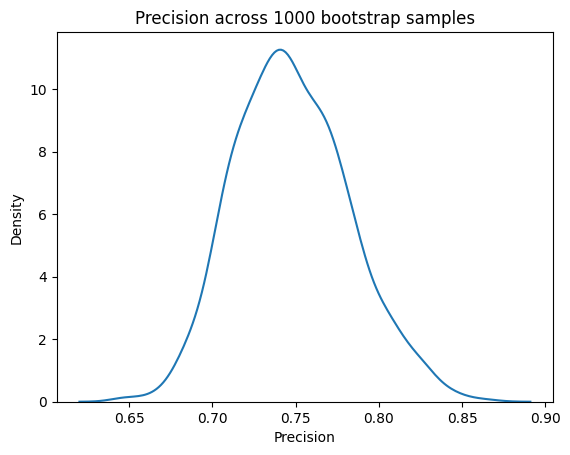

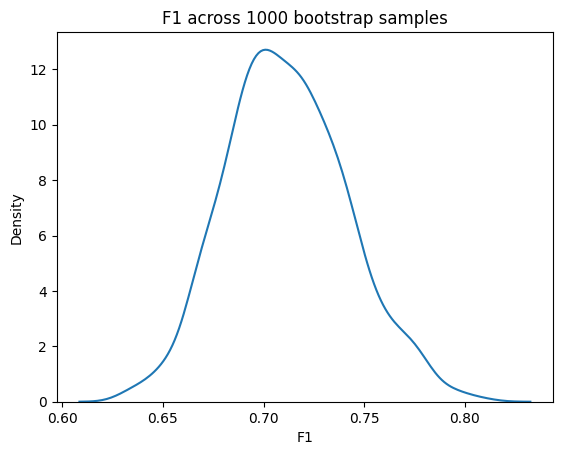

In [280]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import recall_score, precision_score, f1_score
import seaborn as sns

import numpy as np
from sklearn.utils import resample
from sklearn.metrics import recall_score, precision_score, f1_score
import seaborn as sns

def boot_val_print(X_train, y_train, X_test, y_test, y_pred, k_val, data, X_COLS, y_COL, v):
    N_BOOTSTRAPS = 1000
    boot_accuracies = []
    boot_recalls = []
    boot_precisions = []
    boot_f1s = []

    for i in range(N_BOOTSTRAPS):
        
        X_boot, y_boot = resample(X_train, y_train, replace=True)
        
        # reinitialise knn model
        knn = KNeighborsClassifier(n_neighbors=k_val)

        # train the model using the training subset
        knn.fit(X_boot, y_boot)
        
        # predict
        y_pred_boot = knn.predict(X_train)
        
        # evaluate
        boot_accuracies.append(accuracy_score(y_train, y_pred_boot))
        boot_recalls.append(recall_score(y_train, y_pred_boot, average='macro'))
        boot_precisions.append(precision_score(y_train, y_pred_boot, average='macro'))
        boot_f1s.append(f1_score(y_train, y_pred_boot, average='macro'))

    # print results
    print(f"Bootstrapped accuracies: {boot_accuracies}")
    print(f"Bootstrapped recalls: {boot_recalls}")
    print(f"Bootstrapped precisions: {boot_precisions}")
    print(f"Bootstrapped f1s: {boot_f1s}")
    # print averages
    print(f"Mean accuracy: {np.mean(boot_accuracies)}")
    print(f"Mean recall: {np.mean(boot_recalls)}")
    print(f"Mean precision: {np.mean(boot_precisions)}")
    print(f"Mean f1: {np.mean(boot_f1s)}")

    print(f"[{v}]")
    # plot distribution of accuracy
    sns.kdeplot(boot_accuracies)
    plt.title(f"Accuracy across {N_BOOTSTRAPS} bootstrap samples")
    plt.xlabel("Accuracy")
    plt.show()

    # plot distribution of recall
    sns.kdeplot(boot_recalls)
    plt.title(f"Recall across {N_BOOTSTRAPS} bootstrap samples")
    plt.xlabel("Recall")
    plt.show()

    # plot distribution of precision
    sns.kdeplot(boot_precisions)
    plt.title(f"Precision across {N_BOOTSTRAPS} bootstrap samples")
    plt.xlabel("Precision")
    plt.show()

    # plot distribution of f1
    sns.kdeplot(boot_f1s)
    plt.title(f"F1 across {N_BOOTSTRAPS} bootstrap samples")
    plt.xlabel("F1")
    plt.show()
    
boot_val_print(first_X_train, first_y_train, first_X_test, first_y_test, first_y_pred, first_best_k, first_data, first_X_COLS, first_y_COL, V1)
boot_val_print(second_X_train, second_y_train, second_X_test, second_y_test, second_y_pred, second_best_k, second_data, second_X_COLS, second_y_COL, V2)
boot_val_print(third_X_train, third_y_train, third_X_test, third_y_test, third_y_pred, third_best_k, third_data, third_X_COLS, third_y_COL, V3)